# Custard cruise autnomy fleet


In [1]:
import pandas as pd
import numpy as np
import requests
import shutil
import os
import gzip
import matplotlib
from pathlib import Path
import re
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from glob import glob
from datetime import datetime
from scipy import interpolate

In [2]:
#Wmo of the custard cruise floats
wmo_list = [5906216, 5906217, 5906212, 5906213]

#list of url to the nc sprof
floats_url = []
#Floats from the custard cruise are all sstored on the aoml dac
for wmo in wmo_list:
    temp_url = 'https://data-argo.ifremer.fr/dac/aoml/' + str(wmo) + '/' + str(wmo) + '_Sprof.nc'
    floats_url.append(temp_url)

#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
floats_dir =  os.path.join(parent_dir, 'Data/Floats')

#Create floats filename
floats_filenames = []
for i in floats_url:
    filename = floats_dir + '/' + i.rsplit('/', 1)[1]
    floats_filenames.append(filename)

In [6]:
#Download floats data. We do it everytime so we are sure to work with a DAC up to date version. 
#We could check with the synthetic profile index if it is needed to download a update.
for url, filename in zip(floats_url, floats_filenames):
    urlretrieve(url, filename)

# Position of the floats

In [3]:
position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
for file, wmo in zip(floats_filenames, wmo_list):
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    position_df = pd.concat([position_df, temp_df], ignore_index=True)
    dat.close()

C:\Users\flapet\AppData\Local\Temp\ipykernel_17572\3795729912.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  position_df = pd.concat([position_df, temp_df], ignore_index=True)


In [4]:
# load the low resolution world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

C:\Users\flapet\AppData\Local\Temp\ipykernel_17572\3359036695.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


In [ ]:
n = 4
test = np.array(wmo_list) - (min(wmo_list) - 1)
from_list = matplotlib.colors.LinearSegmentedColormap.from_list
cm = from_list(None, plt.cm.Paired(test), n)

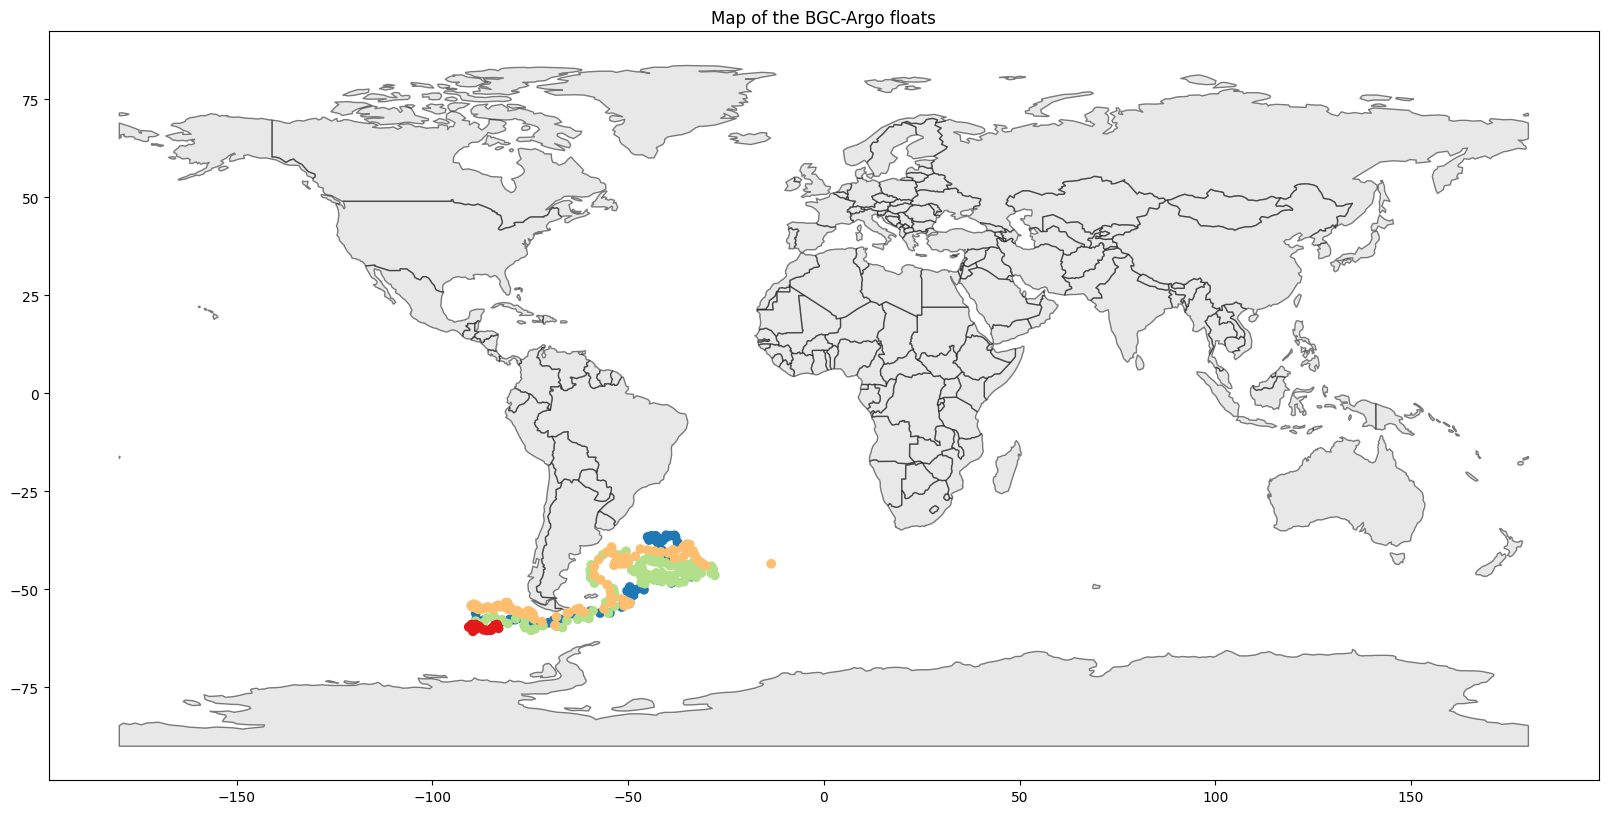

In [34]:
# Create a dictionary to map float values to colors
unique_floats = sorted(position_df['float'].unique())
num_unique_floats = len(unique_floats)
colors = plt.cm.Paired(test)
color_map = {float_val: colors[i] for i, float_val in enumerate(unique_floats)}

# initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

# plot the floats trajectories
scatter = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], c=[color_map[val] for val in position_df['float']])

# set the plot title
plt.title("Map of the BGC-Argo floats")
plt.show()

In [42]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

# Define data's extents I used an arbitrary extent that depicts the region plotted above
min_lon = -100
max_lon = -20
min_lat = -66
max_lat = -25

In [43]:
bath_directory = parent_dir + '/Data/' + "ne_10m_bathymetry_all/"
def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(bath_directory)

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob(bath_directory + '*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (min_lon - 3, max_lon + 3,min_lat - 1, max_lat + 1)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict

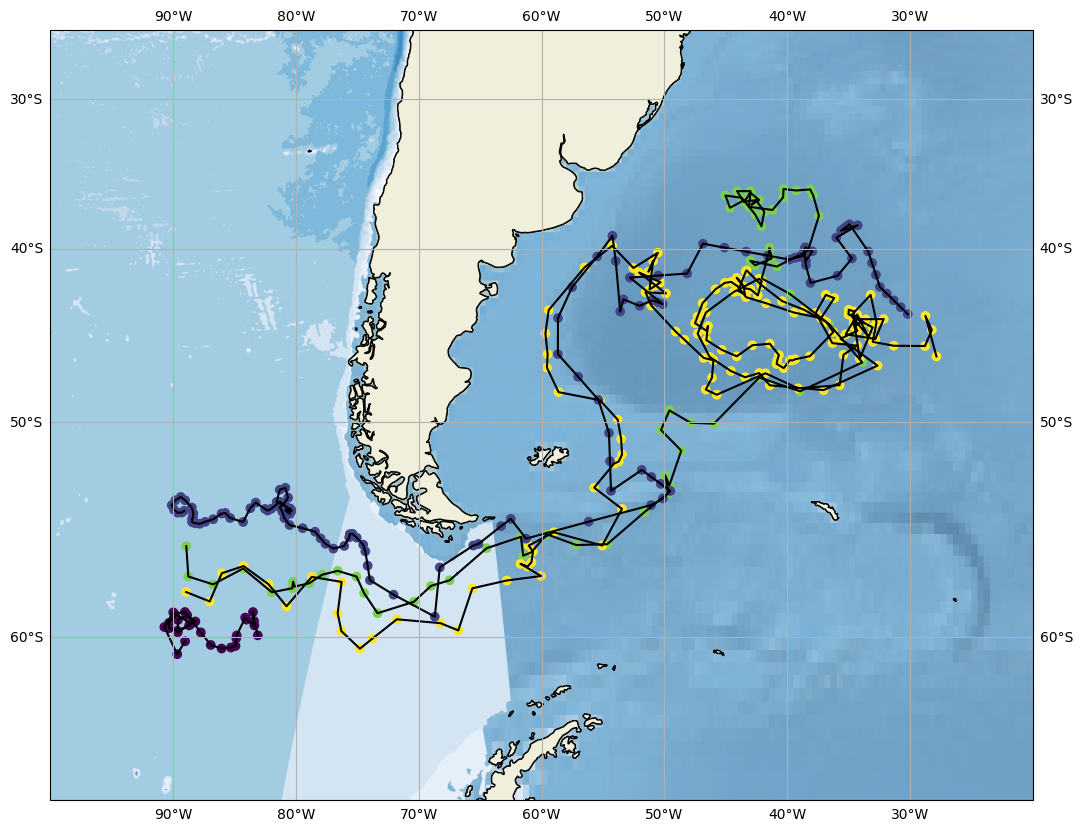

In [46]:
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib
if __name__ == "__main__":
    # Load data (14.8 MB file)
    depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

    # Set up plot
    # Initialize an empty figure and add an axis
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1,
                        projection=ccrs.Mercator())

    # Set the map extent based on your latitude and longitude ranges
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Scatter plot
    sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = position_df['float'], zorder = 2)
    # Plot lines
    for i in wmo_list:
        plot_df = position_df[position_df['float'] == i]
        ax.plot(plot_df['LONGITUDE'], plot_df['LATITUDE'], c='black', transform.=ccrs.PlateCarree())

    # Iterate and plot feature for each depth level
    for i, depth_str in enumerate(depths_str):
        ax.add_geometries(shp_dict[depth_str].geometries(),
                          crs=ccrs.PlateCarree(),
                          color=colors_depths[i])

    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land_50m)
    ax.stock_img()

    # print a grid on it
    gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

    # Convert vector bathymetries to raster (saves a lot of disk space)
    # while leaving labels as vectors
    ax.set_rasterized(True)

# Glider spotting

In [84]:
glider_url = 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Bellamite_20191206/Bellamite_538_R.nc'
gliders_dir =  os.path.join(parent_dir, 'Data/Gliders')

glider_filename = gliders_dir + '/' + glider_url.rsplit('/', 1)[1]

In [86]:
#urlretrieve(glider_url, glider_filename)

('c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz\\Data/Gliders/Bellamite_538_R.nc',
 <http.client.HTTPMessage at 0x2045fc3e8d0>)

In [88]:
dat = xr.open_dataset(glider_filename)
df_glid = dat[['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP', 'CHLA', 'BBP700']].to_dataframe()

dat.close()

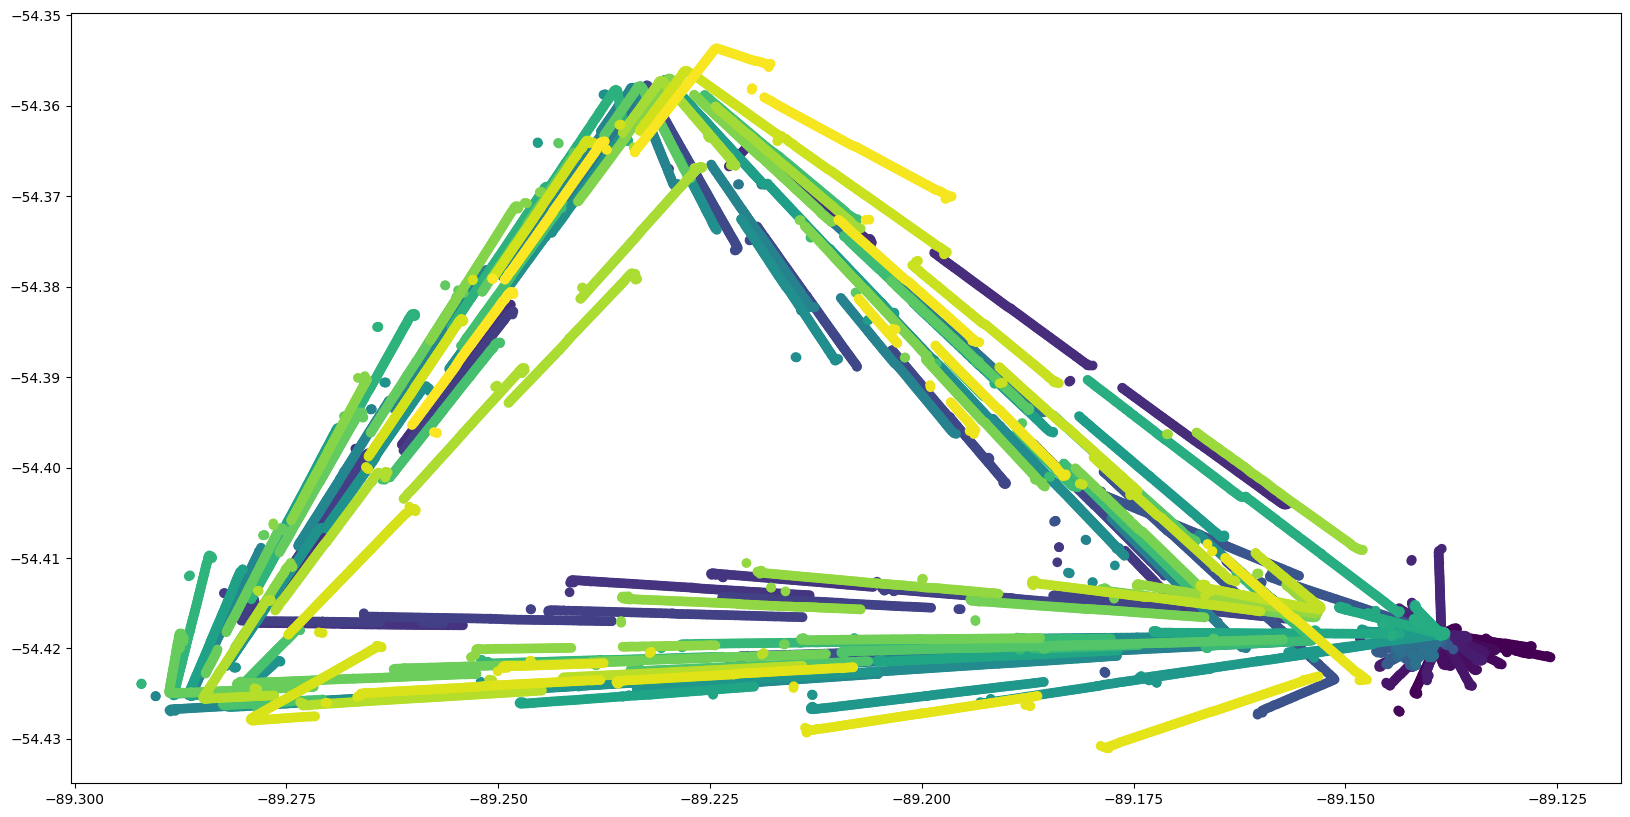

In [113]:
df_tr = df_glid[df_glid['LONGITUDE'] < -88]
df_tr = df_tr[df_tr['LONGITUDE'] < -20]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)

ax.scatter(df_tr['LONGITUDE'], df_tr['LATITUDE'], c = df_tr['TIME'])

plt.show()

In [108]:
df_tr.head()

,TIME,LATITUDE,LONGITUDE,PRES,TEMP,CHLA,BBP700
N_MEASUREMENTS,,,,,,,
42,2019-12-03 17:36:12.675751424,-52.656166,-78.642067,NaN,NaN,NaN,NaN
46,2019-12-03 17:37:12.973816064,-52.656078,-78.646294,NaN,NaN,NaN,NaN
50,2019-12-03 17:38:15.138580224,-52.656181,-78.649834,NaN,NaN,NaN,NaN
54,2019-12-03 17:39:20.161926144,-52.656193,-78.653687,NaN,NaN,NaN,NaN
57,2019-12-03 17:40:21.236420352,-52.656303,-78.657898,NaN,NaN,NaN,NaN


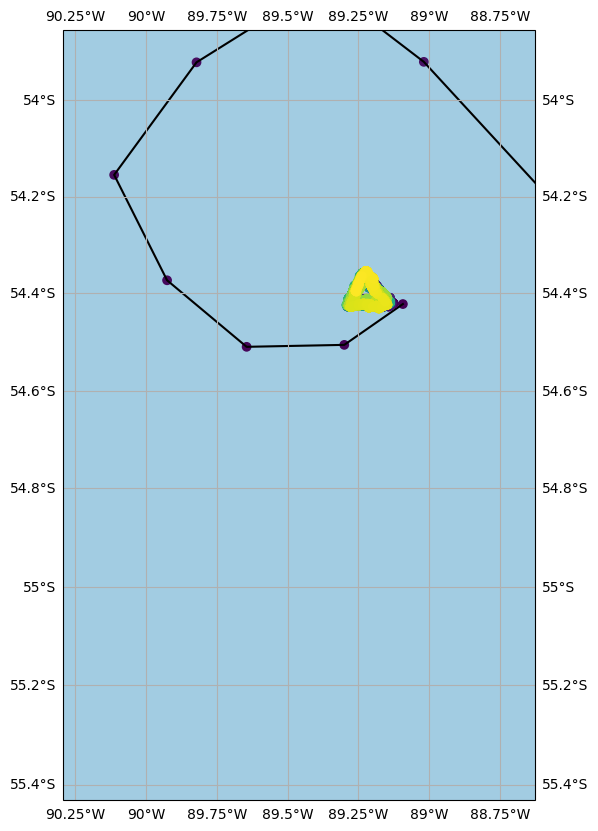

In [114]:
position_float = position_df[position_df['float'] == 5906213]

min_lon = min(df_tr['LONGITUDE']) - 1
max_lon = max(df_tr['LONGITUDE']) + 0.5
min_lat = min(df_tr['LATITUDE']) - 1
max_lat = max(df_tr['LATITUDE']) + 0.5
# Construct a discrete colormap with colors corresponding to each depth
depths = depths_str.astype(int)
N = len(depths)
nudge = 0.01  # shift bin edge slightly to include data
boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
norm = matplotlib.colors.BoundaryNorm(boundaries, N)
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
colors_depths = blues_cm(norm(depths))

# Set up plot
# Initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1,
                    projection=ccrs.Mercator())

# Set the map extent based on your latitude and longitude ranges
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Scatter plot
sc = ax.scatter(position_float['LONGITUDE'], position_float['LATITUDE'], transform=ccrs.PlateCarree(), c = position_float['PROF_NUM'], zorder = 2)
sc2 = ax.scatter(df_tr['LONGITUDE'], df_tr['LATITUDE'], transform=ccrs.PlateCarree(), c = df_tr['TIME'], zorder = 3)
# Plot lines
ax.plot(position_float['LONGITUDE'], position_float['LATITUDE'], c='black', transform=ccrs.PlateCarree())

# Iterate and plot feature for each depth level
for i, depth_str in enumerate(depths_str):
    ax.add_geometries(shp_dict[depth_str].geometries(),
                        crs=ccrs.PlateCarree(),
                        color=colors_depths[i])

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(land_50m)
ax.stock_img()

# print a grid on it
gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

# Convert vector bathymetries to raster (saves a lot of disk space)
# while leaving labels as vectors
ax.set_rasterized(True)

## Profile plotting

In [115]:
dat = xr.open_dataset(floats_filenames[2])
df = dat[['JULD', 'PRES_ADJUSTED', 'TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'CHLA_ADJUSTED', 'BBP700_ADJUSTED', 'DOXY_ADJUSTED']].to_dataframe()
dat.close()

In [77]:
df = df.dropna()

In [81]:
last_date = max(df['JULD'])

last_df = df[df['JULD'] == last_date]
early_df = df[df['JULD'] < last_date]

early_df = early_df.reset_index()
alphas = early_df['N_PROF']/(max(early_df['N_PROF']))

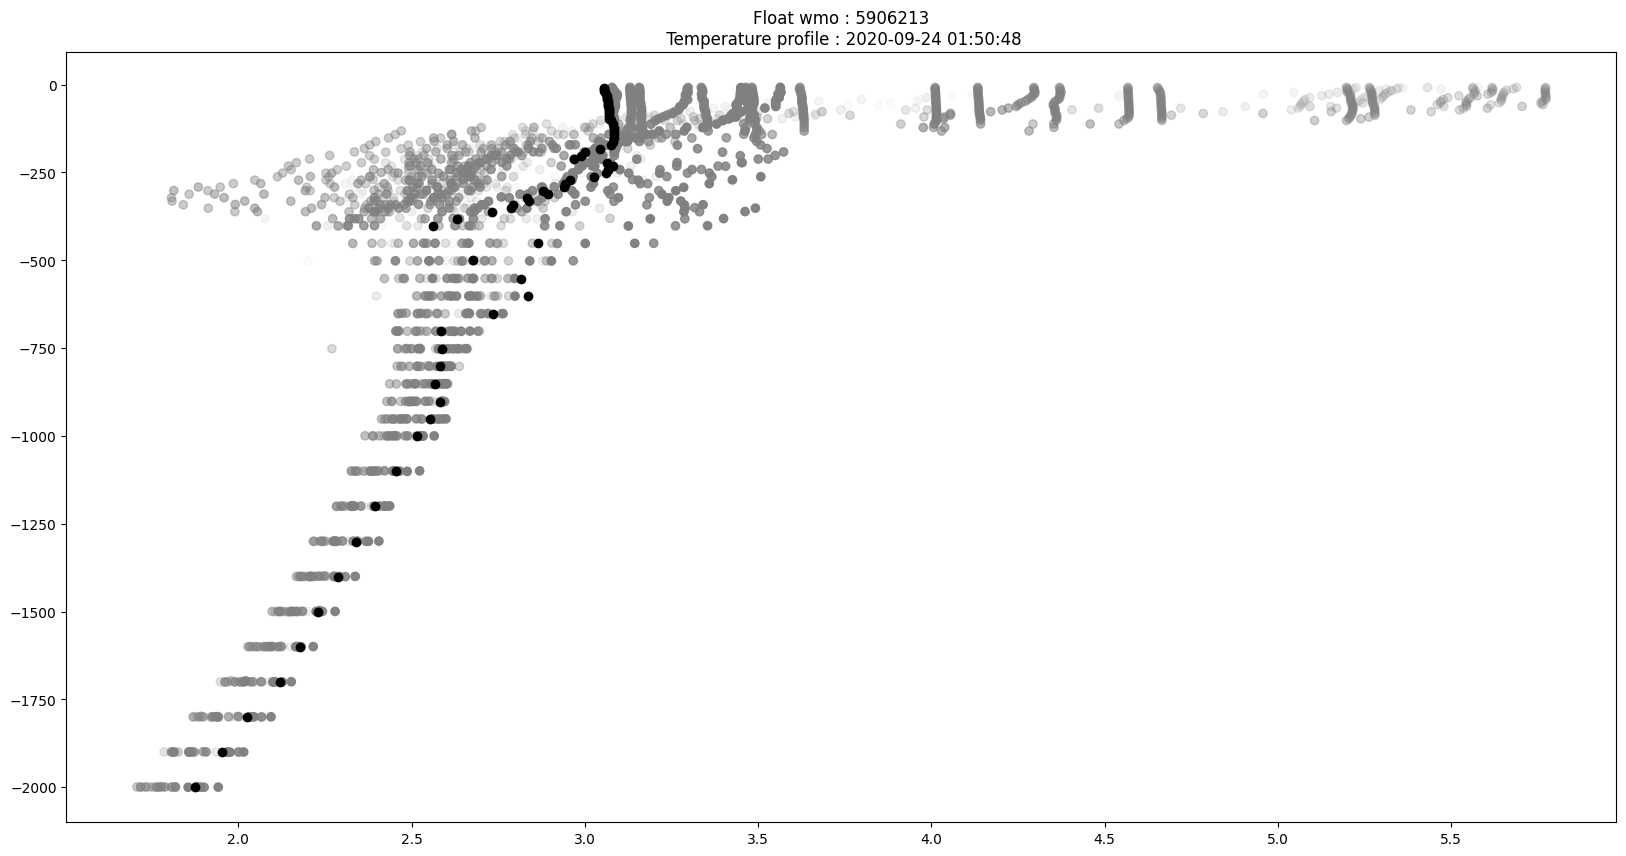

In [82]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['TEMP_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas, c = 'grey')
sc = ax.scatter( last_df['TEMP_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)

# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Temperature profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

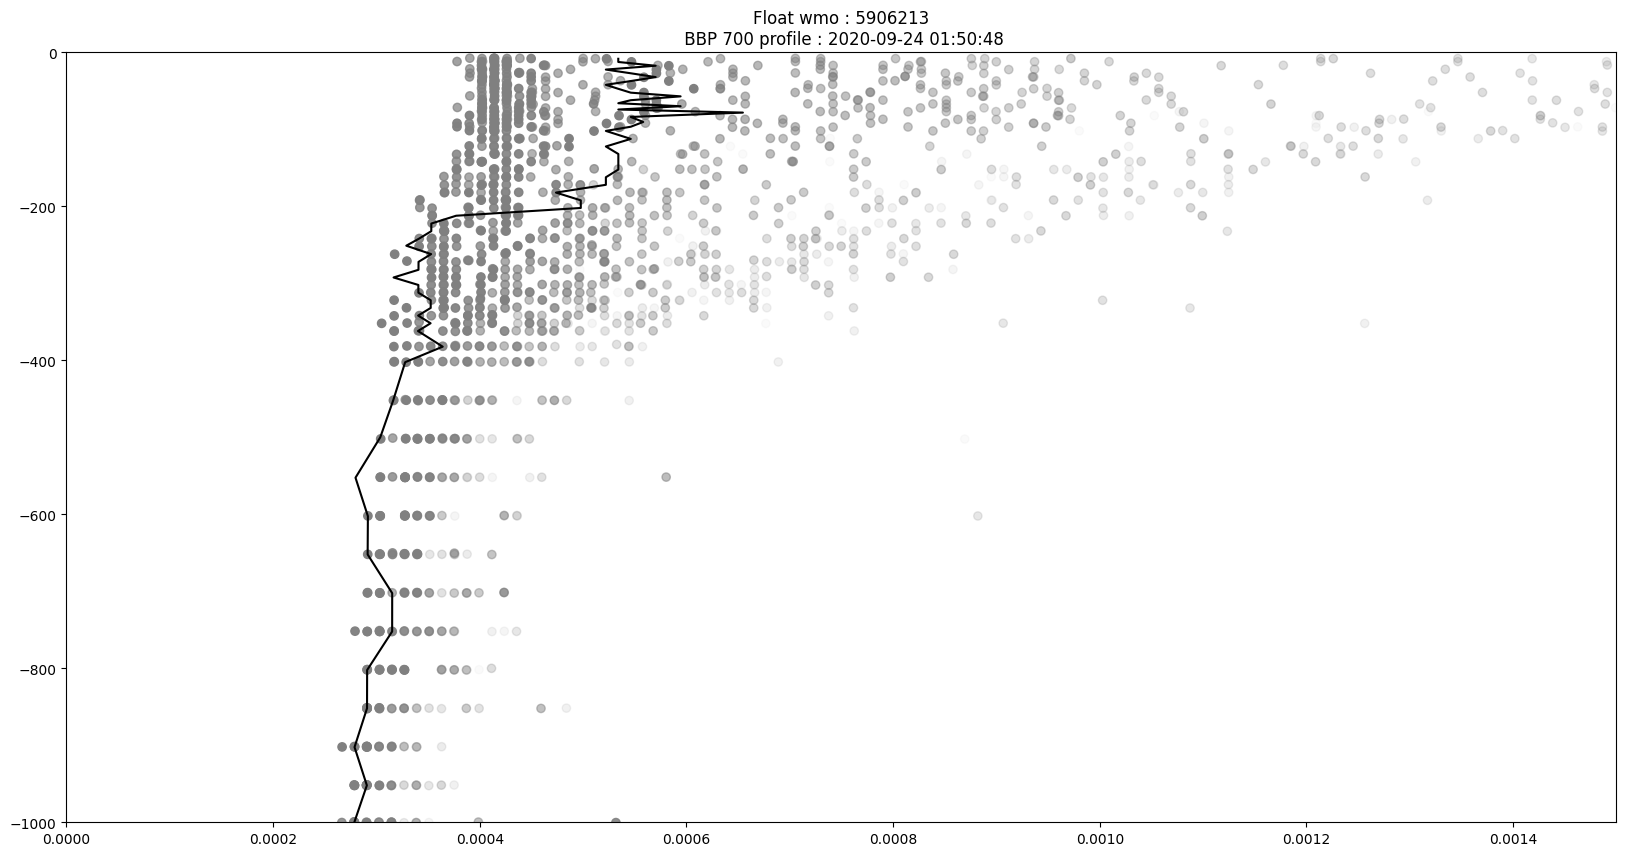

In [83]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['BBP700_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas, c = 'grey')
sc = ax.plot( last_df['BBP700_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)
ax.set_ylim([-1000,0])
ax.set_xlim([0,0.0015])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n BBP 700 profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()